In [1]:
import cv2
import csv
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pylab as pl
import bobsegutils as bsu
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_path = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
src_img = imread(image_path)
img_size = src_img.shape
row_size = range(0,img_size[1])
col_size = range(0,img_size[2])
print(img_size)

(61, 836, 628)


In [3]:
Xpts = range(0, img_size[1])
Ypts = range(0, img_size[2])
Points = np.array(list(itertools.product(Xpts, Ypts))).astype(float32)

In [4]:
image_index = 2 # The image time point(exclusive of) until which TSP is to be applied based on selected control points
flow_x = np.zeros(shape=(image_index,img_size[1],img_size[2]))
flow_y = np.zeros(shape=(image_index,img_size[1],img_size[2]))

### Thin Plate Spline Based Warping/Flow Estimation

In [5]:
with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv', 'r') as f:
    reader = csv.reader(f)
    uncertainty_radius_list_full = list(reader)
uncertainty_radius_list_full = uncertainty_radius_list_full[1:]
uncertainty_radius_list_full=np.array(uncertainty_radius_list_full,integer)
uncertainty_radius_list_full = [item for sublist in uncertainty_radius_list_full for item in sublist]
print(uncertainty_radius_list_full)

[3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


In [6]:
uncertainty_radius_list_full = np.array(uncertainty_radius_list_full)
zero_uncertainty_index = np.where(uncertainty_radius_list_full == 0)[0]
nonzero_uncertainty_index = np.where(uncertainty_radius_list_full != 0)[0]

In [7]:
### Reading only certain indices (with uncertainty readius = 0) for warping

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    certain_source_rows=[row for idx, row in enumerate(source_reader) if idx in zero_uncertainty_index]
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    certain_target_rows=[row for idx, row in enumerate(target_reader) if idx in zero_uncertainty_index]
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

In [8]:
### Reading only uncercertain indices (with uncertainty readius !=0) for validation of warped flow

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv') as fd:
    uncertainty_radius_reader=csv.reader(fd)
    next(uncertainty_radius_reader)
    uncertain_radius_rows=[row for idx, row in enumerate(uncertainty_radius_reader) if idx in nonzero_uncertainty_index]

In [9]:
certain_sshape = np.array(certain_source_rows,float)
certain_tshape = np.array(certain_target_rows, float)

uncertain_sshape = np.array(uncertain_source_rows, float)
uncertain_tshape = np.array(uncertain_target_rows, float)
uncertain_radius_list = np.array(uncertain_radius_rows, float)

In [10]:
for index in range(1, image_index,1):
    tps = cv2.createThinPlateSplineShapeTransformer()
    certain_sshape = certain_sshape.reshape(1,-1,2)
    certain_tshape = certain_tshape.reshape(1,-1,2)
    matches = list()

    for i in range(0, certain_sshape.shape[1],1):
        matches.append(cv2.DMatch(i,i,0))

    tps.estimateTransformation(certain_sshape,certain_tshape,matches)  
    ret, tshape_ = tps.applyTransformation (Points.reshape(1,-1,2))
    target_warp = tshape_.reshape(img_size[1],img_size[2],2)

    # Creating flow
    tsp_flow_x = np.zeros(shape=(img_size[1],img_size[2]))
    tsp_flow_y = np.zeros(shape=(img_size[1],img_size[2]))

    for row in range(img_size[1]):
        for col in range(img_size[2]):
            tsp_flow_x[row][col] = target_warp[row][col][0] - row
            tsp_flow_y[row][col] = target_warp[row][col][1] - col
    flow_x[index-1,:,:] = tsp_flow_x
    flow_y[index-1,:,:] = tsp_flow_y

In [11]:
validation_query_point_list = uncertain_sshape
validation_result_point_list = uncertain_tshape

In [12]:
flow_points_flat_list = []

In [13]:
for number in range(0, len(validation_query_point_list), 1):
#     print("Validation Query Point:", validation_query_point_list[number])
#     print("Validation Result Point:", validation_result_point_list[number])
#     print("TPS Flow Result:", target_warp[int(validation_query_point_list[number][0]), int(validation_query_point_list[number][1])])
    flow_points_flat_list.append(target_warp[int(validation_query_point_list[number][0]), int(validation_query_point_list[number][1])])

In [14]:
print(len(validation_query_point_list))
print(len(validation_result_point_list))

109
109


### Quantification

In [15]:
pixel_lag = []
relative_pixel_lag = []
count = 0
for i in range(len(flow_points_flat_list)):
    if(bsu.euclid_dist(flow_points_flat_list[i], validation_result_point_list[i])<= uncertain_radius_list[i]):
        
        position_offset = 0
        relative_position_offset = 0
        count = count +1
    else:
        r2 = bsu.euclid_dist(validation_query_point_list[i], flow_points_flat_list[i])
        r1 = bsu.euclid_dist(validation_query_point_list[i], validation_result_point_list[i])
        position_offset = r2-r1
        relative_position_offset = abs(position_offset)/r1
        
    
    pixel_lag.append(position_offset)
    relative_pixel_lag.append(relative_position_offset*100)

/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


In [16]:
print(relative_pixel_lag)

[269.8099832814417, 82.67626447485223, 126.88257739024091, 145.05740856726464, 69.19815210074472, 72.06841805133162, 59.87369538455596, 13.846456223352769, 97.07680041490615, 9.53041986239277, 24.523803568775282, 243.6463864622602, 233.94264016201623, 14.388949941496188, 87.8548851892884, 109.3828111097157, 183.6669729153822, 50.189895606569415, 44.50443030340664, 73.64317081916958, 35.300998029577336, 0, 48.24568657336981, 0, 27.648828692217364, 51.72829658018242, 45.50252526482153, 36.64137099115851, 10.20099702229229, 8.153101513624108, 22.959981320473354, 146.25100988366148, 68.39540004451908, 123.14721345854586, 45.9141881170692, 158.29628722350296, 59.97608353823024, 49.16466968414542, 61.36237948707042, 41.80641735688264, 52.87409183316755, 83.67451186266877, 41.481702596398804, 50.29577863928185, 63.37750820285374, 91.5409850647588, 42.83746872940727, 54.41427044356114, 22.748669871002434, 52.99199660394309, 17.144101500046403, 45.69293037945626, 4.642537750278559, 29.089516674

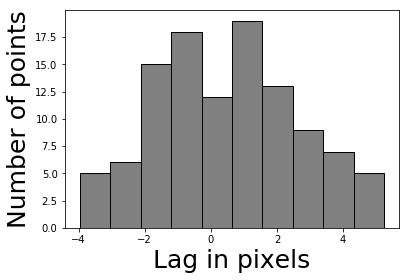

In [17]:
plt.hist(pixel_lag,histtype='bar', color='gray', ec='black')
plt.xlabel('Lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [26]:
print(np.median(pixel_lag))
print(np.median(relative_pixel_lag))
print(np.percentile(pixel_lag,75))
print(np.percentile(relative_pixel_lag,20))

0.5340787253728903
45.9141881170692
1.9533832510609286
17.142378025478838
